# Experiment parameters

In [1]:
import sys
sys.path.append("../")
import numpy as np
import scipy as sp
from utils import (
    grid_adj_mat,
    grid_gos_mat,
    ring_adj_mat,
    ring_gos_mat,
    star_adj_mat,
    star_gos_mat,
)

In [2]:
datasets = ["fourclass"] #["a7a", "a9a", "w7a", "w8a", "phishing"]
# max number of iterations for finding saddle with extragradient
num_iter_solution = 500000

# max time for finding saddle with extragradient
max_time_solution = 3600
# tolerance of solution obtained with extragradient
tolerance_solution = 1e-10
# required accuracy of sliding
eps = 1e-10
seed = 30

In [3]:
# number of nodes
num_nodes = 25
# for grid graph
width = int(np.sqrt(num_nodes))  
regcoef_x = 2.0
regcoef_y = 2.0
r_x = 5.0
r_y = 0.1
comm_budget_experiment = 5000

In [4]:
adj_mat = {
    "star": star_adj_mat(num_nodes),
    "grid": grid_adj_mat(width, width),
    "ring": ring_adj_mat(num_nodes),
}
gos_mat = {
    "star": star_gos_mat(num_nodes),
    "grid": grid_gos_mat(width, width),
    "ring": ring_gos_mat(num_nodes),
}

/home/michael/Documents/DistributedOpt/opt_distr_stoch_vi/decentralized/../decentralized/utils/generate_matrices.py:122: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return np.array(nx.linalg.graphmatrix.adjacency_matrix(graph).todense()).astype(np.float64)
/home/michael/Documents/DistributedOpt/opt_distr_stoch_vi/decentralized/../decentralized/utils/generate_matrices.py:104: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return np.array(nx.linalg.graphmatrix.adjacency_matrix(graph).todense()).astype(np.float64)
<class 'networkx.utils.decorators.argmap'> compilation 16:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


# Dataset

In [8]:
from libsvmdata import fetch_libsvm

In [9]:
A, b = fetch_libsvm(datasets[0])
if sp.sparse.issparse(A):
    A = A.toarray()

In [10]:
A.shape

(862, 2)

In [11]:
from decentralized.oracles import ArrayPair

In [12]:
z_0 = ArrayPair.zeros(A.shape[1])

# Oracles

In [13]:
from utils import get_oracles

In [14]:
oracles, oracle_mean, L, delta, mu, A_grad, b_grad = get_oracles(
    A,
    b,
    num_nodes,
    regcoef_x,
    regcoef_y,
    r_x,
    r_y,
)

L = 52155.547, delta = 12934.517, mu = 2.000


# Run

In [15]:
from utils import metropolis_weights

In [16]:
graph = "grid"
mix_mat = metropolis_weights(adj_mat[graph])
W = gos_mat[graph]

## Solving linear regression

In [17]:
# x = np.linalg.inv(A_theor) @ b_theor
# x = np.linalg.solve(A_grad, b_grad)

In [18]:
x = np.linalg.lstsq(A_grad, b_grad, rcond=None)[0]

In [19]:
np.linalg.norm(x)

0.009919192852232668

In [20]:
z_true = ArrayPair(x, np.zeros(A.shape[1]))

In [21]:
z_true.x

array([ 0.00608101, -0.00783656])

In [22]:
g_true = ArrayPair(
    np.zeros((num_nodes, z_true.x.shape[0])), np.zeros((num_nodes, z_true.y.shape[0]))
)

## Centralized Extragradient

In [23]:
from utils import solve_with_extragradient_real_data

In [ ]:
z_true = solve_with_extragradient_real_data(
    A=A,
    b=b,
    regcoef_x=regcoef_x,
    regcoef_y=regcoef_y,
    r_x=r_x,
    r_y=r_y,
    num_iter=num_iter_solution,
    max_time=max_time_solution,
    tolerance=tolerance_solution,
)

In [ ]:
z_true.x

## Decentralized Extragradient method

In [24]:
from experiment import run_extragrad_gt

In [25]:
extragrad = run_extragrad_gt(
    oracles=oracles,
    L=L,
    mu=mu,
    z_0=z_0,
    z_true=z_true,
    g_true=g_true,
    mix_mat=mix_mat,
    r_x=r_x,
    r_y=r_y,
    comm_budget_experiment=comm_budget_experiment,
)

Running decentralized extragradient...
argument_primal_distance_to_consensus, argument_primal_distance_to_opt, gradient_primal_distance_to_opt can be accessed at corresponding logger class fields.


## Decentralized Extragradient method with consensus subroutine

In [27]:
from experiment import run_extragrad_con

In [28]:
extragrad_con = run_extragrad_con(
    oracles=oracles,
    L=L,
    mu=mu,
    z_0=z_0,
    z_true=z_true,
    g_true=g_true,
    mix_mat=mix_mat,
    r_x=r_x,
    r_y=r_y,
    eps=eps,
    comm_budget_experiment=comm_budget_experiment,
)

Running decentralized extragradient-con...
T_consensus = 117
argument_primal_distance_to_consensus, argument_primal_distance_to_opt, gradient_primal_distance_to_opt can be accessed at corresponding logger class fields.


## Decentralized gradient sliding

In [29]:
from experiment import run_sliding

In [30]:
sliding = run_sliding(
    oracles=oracles,
    L=L,
    delta=delta,
    mu=mu,
    z_0=z_0,
    z_true=z_true,
    g_true=g_true,
    mix_mat=mix_mat,
    r_x=r_x,
    r_y=r_y,
    eps=eps,
    comm_budget_experiment=comm_budget_experiment,
)

Running decentralized sliding...
H_0 = 182, H_1 = 176, T_subproblem = 8
argument_primal_distance_to_consensus, argument_primal_distance_to_opt, gradient_primal_distance_to_opt can be accessed at corresponding logger class fields.


## Decentralized Algorithm 1

In [31]:
from experiment import run_vi_papc

In [32]:
vi_papc = run_vi_papc(
    num_nodes=num_nodes,
    oracles=oracles,
    L=L,
    mu=mu,
    z_0=z_0,
    z_true=z_true,
    g_true=g_true,
    gos_mat=W,
    r_x=r_x,
    r_y=r_y,
    comm_budget_experiment=comm_budget_experiment,
)

Running decentralized VI PAPC...
argument_primal_distance_to_consensus, argument_primal_distance_to_opt, gradient_primal_distance_to_opt can be accessed at corresponding logger class fields.


## Decentralized Alogorithm 2

In [33]:
from experiment import run_vi_adom

In [34]:
batch_size = len(oracles)
L_avg = L

In [35]:
x_0 = ArrayPair.zeros(A.shape[1])
y_0 = ArrayPair.zeros(A.shape[1])        

In [36]:
vi_adom = run_vi_adom(
    num_nodes=num_nodes,
    oracles=oracles,
    b=batch_size,
    L=L,
    L_avg=L_avg,
    mu=mu,
    x_0=x_0,
    y_0=y_0,
    z_0=z_0,
    z_true=z_true,
    g_true=g_true,
    gos_mat=W,
    r_x=r_x,
    r_y=r_y,
    comm_budget_experiment=comm_budget_experiment,
)

Running decentralized VI ADOM...
argument_primal_distance_to_consensus, argument_primal_distance_to_opt, gradient_primal_distance_to_opt can be accessed at corresponding logger class fields.


# Preplot

In [37]:
from experiment import preplot_algorithms

In [38]:
#labels = ['EGD-GT', 'EGD-CON', 'Sliding', 'Alg.1']
labels = ['EGD-GT', 'EGD-CON', 'Sliding', 'Alg.2']

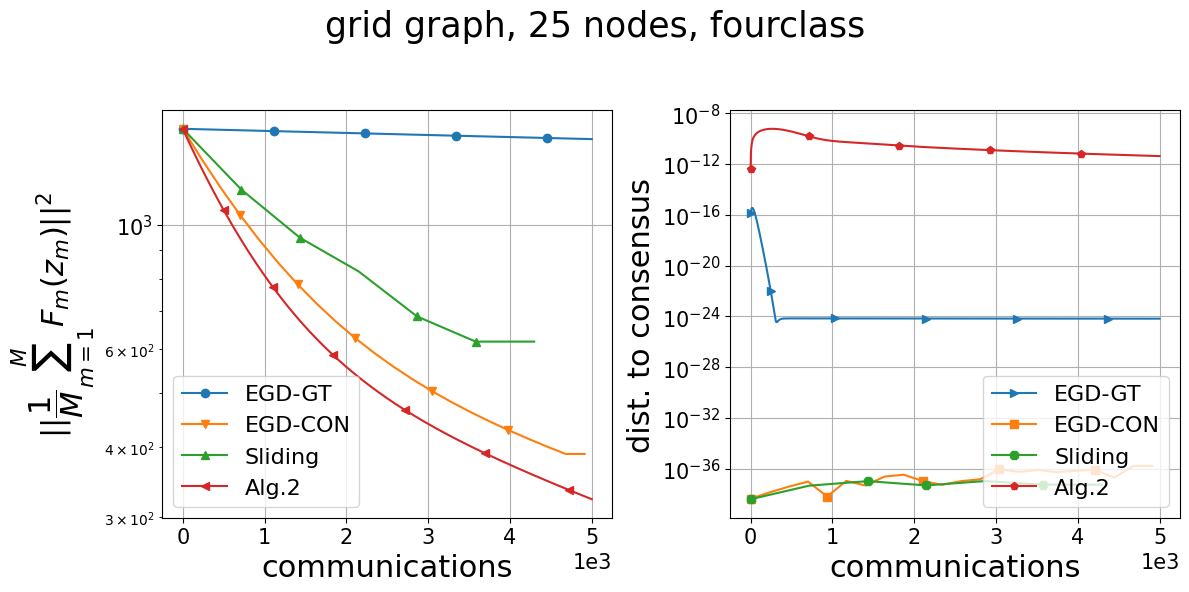

In [39]:
preplot_algorithms(
    topology=graph,
    num_nodes=num_nodes,
    data=datasets[0],
    labels=labels,
    #methods=[extragrad, extragrad_con, sliding, vi_papc],
    methods=[extragrad, extragrad_con, sliding, vi_adom],
    dist_to_opt_type="gradient",
)

# Save

In [40]:
from experiment import save_algorithms

In [51]:
#method_names = ['extragrad', 'extragrad_con', 'sliding', 'vi_papc']
method_names = ['extragrad', 'extragrad_con', 'sliding', 'vi_adom']

In [52]:
save_algorithms(
    topology=graph,
    num_nodes=num_nodes,
    data=datasets[0],
    #methods=[extragrad, extragrad_con, sliding, vi_papc],
    methods=[extragrad, extragrad_con, sliding, vi_adom],
    method_names=[f"{method_name}.pkl" for method_name in method_names],
    z_true=z_true,
    experiment_type="real",
)

# Plot

In [53]:
from experiment import plot_algorithms

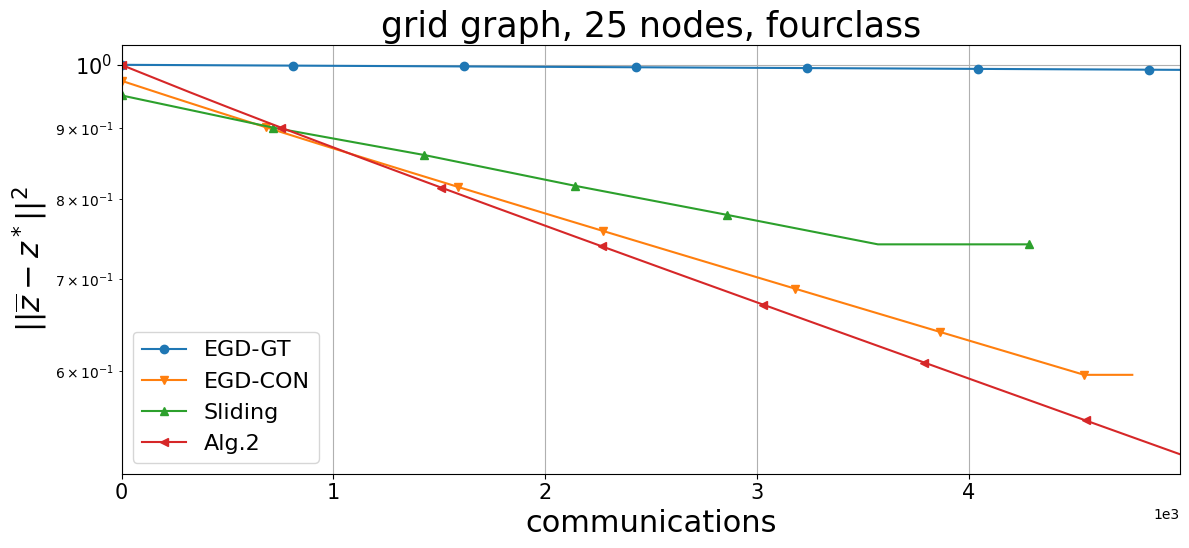

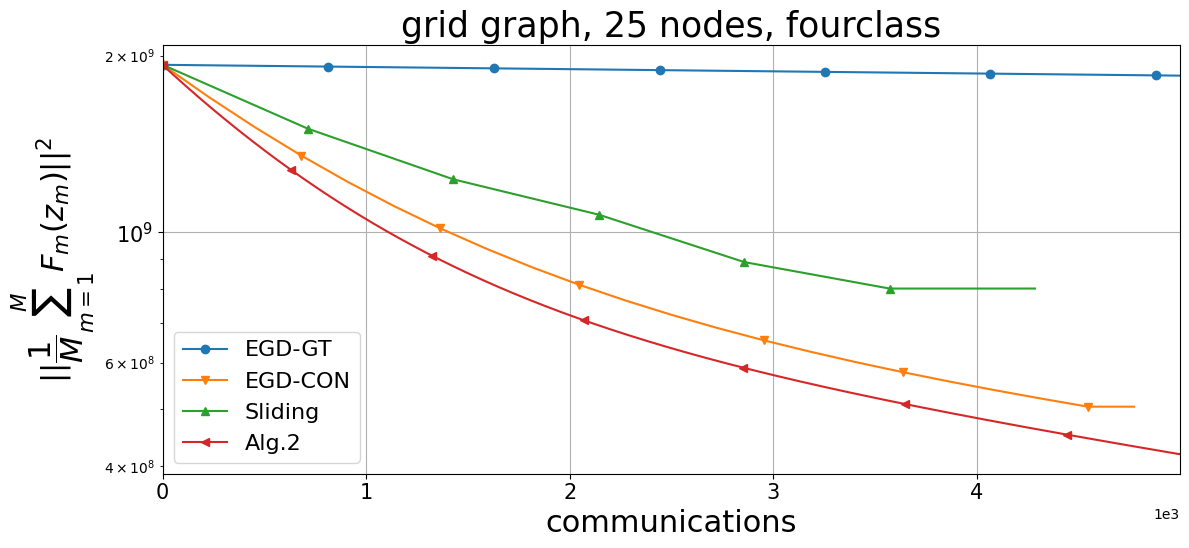

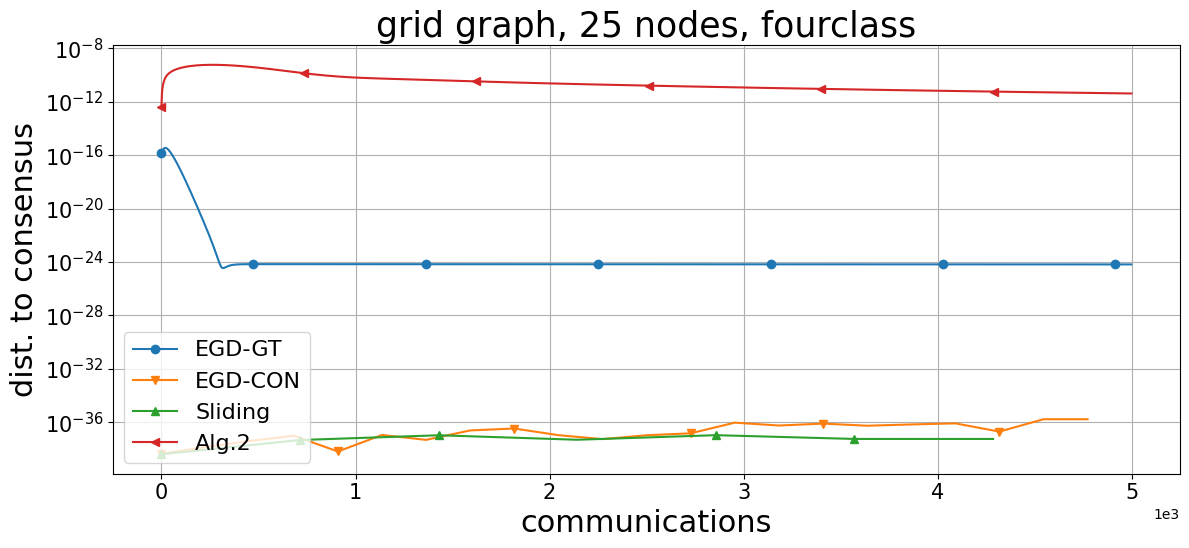

In [54]:
plot_algorithms(
    topology=graph,
    num_nodes=num_nodes,
    data=datasets[0],
    labels=labels,
    method_names=method_names,
    comm_budget_experiment=comm_budget_experiment,
)

# Experiment

In [ ]:
from experiment import run_experiment

In [ ]:
from typing import Tuple

def get_A_b(data: str) -> Tuple[np.ndarray, np.ndarray]:
    A, b = fetch_libsvm(data)
    if sp.sparse.issparse(A):
        A = A.toarray()
    
    return A, b

In [ ]:
methods = ["extragrad", "extragrad_con", "sliding", "vi_papc"]

In [ ]:
topologies = ["ring"]#["star", "grid", "ring"]

In [ ]:
run_experiment(
    methods=methods,
    topologies=topologies,
    datasets=datasets,
    adj_mat=adj_mat,
    gos_mat=gos_mat,
    num_nodes=num_nodes,
    labels=labels,
    regcoef_x=regcoef_x,
    regcoef_y=regcoef_y,
    r_x=r_x,
    r_y=r_y,
    eps=eps,
    num_iter_solution=num_iter_solution,
    max_time_solution=max_time_solution,
    tolerance_solution=tolerance_solution,
    comm_budget_experiment=comm_budget_experiment,
    experiment_type="real",
    get_A_b=get_A_b,
)

# Optimal Parameter Search

In [ ]:
from experiment import run_parameter_search

In [ ]:
run_parameter_search(
    methods=methods,
    topologies=topologies,
    datasets=datasets,
    adj_mat=adj_mat,
    gos_mat=gos_mat,
    num_nodes=num_nodes,
    labels=labels,
    regcoef_x=regcoef_x,
    regcoef_y=regcoef_y,
    r_x=r_x,
    r_y=r_y,
    eps=eps,
    comm_budget_experiment=comm_budget_experiment,
    experiment_type="real",
    get_A_b=get_A_b,
    stepsize_factors=[3.0, 0.1, 0.01, 0.001]
)